# Import Library

In [7]:
import matplotlib.pyplot as plt
import matplotlib
import cv2 as cv
import numpy as np
import usrLibraryUnsymmetrical as lib
import random
from concurrent.futures import ProcessPoolExecutor, as_completed

# Setting the Condition

In [10]:
class optical_condition:
    L:      float # distance from the sample plane to the detector plane
    p:      float # pixel size of the detector
    Npixel: int   # window size of the probe function, object functions, and diffraction patterns
    energy: float # x-ray energy of the incident beam
    h:      float # plank constant
    c:      float # velocity of the light
    lamb:   float # wavelength
    k:      float # wavenumber
    dx:     float # pixel resolution at the sample plane
    DR:     float # dynamic range of the detector, for example opt.DR = log10{1e7 (photons) / 1 (photon}
    Wnoise: bool  # flag to apply photon shot noise to each calculated diffraction pattern


opt         = optical_condition()

opt.L       = 3                                         # unit: m
opt.p       = 75e-6                                     # unit: m
opt.Npixel  = 1024                                      # unit: pixel
opt.energy  = 5000                                      # unit: eV (electronVolt)
opt.h       = 6.62607015e-34                            # unit: m^2 kg/s
opt.c       = 299792458                                 # unit: m/s
opt.lamb    = (opt.h * 6.242e18) * opt.c / opt.energy   # unit: m
opt.k       = 2 * np.pi / opt.lamb                      # unit: 1/m
opt.dx      = opt.L * opt.lamb / (opt.Npixel * opt.p)   # unit: m/pixel
opt.DR      = 7
opt.Wnoise  = True

In [19]:
class aperture_condition:
    sideNumber:         int     # number of the side
    sideLength:         float   # length of a side
    sideLengths:        list    # list of random sideLengths
    Lpropagation:       float   # distance from the aperture to the sample
    needPropagation:    bool    # flag whether propagation from the aperture to the sample is needed

aper = aperture_condition()

aper.sideNumber     = 5                  # input: 3 --> Triangle
aper.sideLength     = 5e-6               # unit: m
aper.sideLengths    = [aper.sideLength * random.uniform(0.5, 1.5) for _ in range(aper.sideNumber)] #5e-7  # unit: m
aper.Lpropagation   = 5e-4               # unit: m, range: # 500-1000*10^-6

if aper.Lpropagation > 0:
    aper.needPropagation = True
else:
    aper.needPropagation = False

In [12]:
class particle_condition:
    beta_Au:    float # parameter related to the absorption of the wavefield
    delta_Au:   float # parameter related to the phase shift of the wavefield
    diameter:   float # diameter of the gold nanoparticle
    ratio:      float # (Area occupied with gold nanoparticles) / (Area of the window, Npixel x Npixel)
    number:     int   # total number of the gold nanoparticles within the window
    velocity:   float # displacement of the gold nanoparticles (per frame)

par = particle_condition()

par.beta_Au     = 2.633e-5
par.delta_Au    = 1.2143e-4
par.diameter    = 150e-9 #300e-9 # unit: m
par.ratio       = 100e-3
par.number      = int(np.floor((opt.Npixel * opt.dx)**2 / (np.pi * (par.diameter / 2)**2) * par.ratio))
par.Nframe      = 1
par.velocity    = 1 * opt.dx    # unit: m/frame

In [13]:
print(opt.dx)

9.687027375252824e-09


# Function Calculation

In [20]:
# set different seed per n frame
np.random.seed(1)

aperture = lib.calcApertureUnsymmetrical(opt, aper)
smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
if aper.needPropagation == 1:
    inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
else:
    inwave = aperture

AuNPimg = lib.calcAuNP(opt, par)

wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

difImg       = np.abs(wavedetector)**2

# diffraction patterns are normalized so that its dynamic range become "opt.DR"
maxCount     = difImg.max()
difImg       = difImg / maxCount * 10**(opt.DR)
isCounted    = np.where(difImg >= 1, 1, 0)
difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

# 2-4-3, apply photon shot noise if "opt.Wnoise" is True
if opt.Wnoise == 1:
    difImgWnoise = np.random.poisson(difImg)

0


# Output Image from Simulator

## Absolute

### Without the Aperture

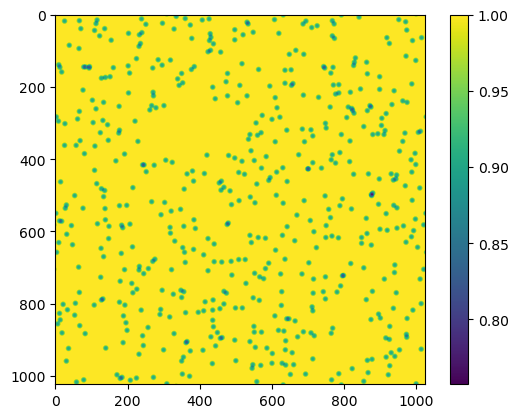

In [15]:
for i in range(par.Nframe):
    plt.imshow(np.abs(AuNPimg[:, :, i]))
    plt.colorbar()
    plt.show()

### With the Aperture

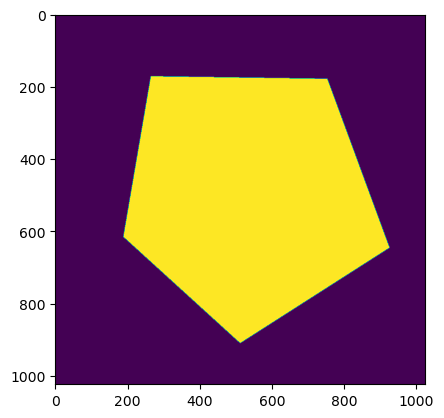

In [21]:
plt.imshow(aperture)

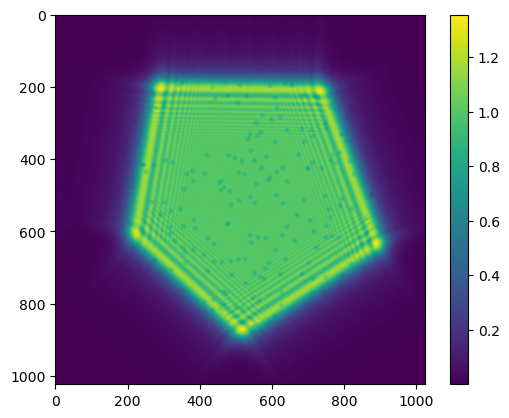

In [22]:
for i in range(par.Nframe):
    plt.imshow(np.abs(AuNPimg[:, :, i]*inwave))
    plt.colorbar()
    plt.show()

## Angle

### Without Aperture

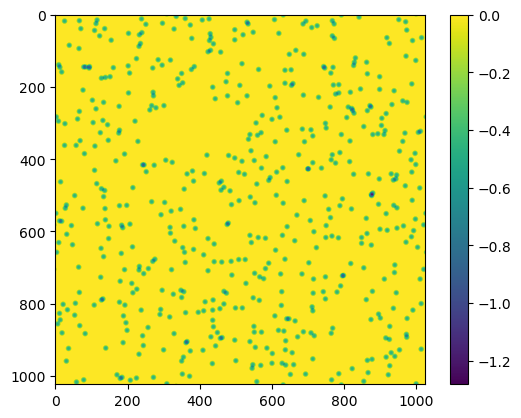

In [31]:
for i in range(par.Nframe):
    plt.imshow(np.angle(AuNPimg[:, :, i]))
    plt.colorbar()
    plt.show()

### With Aperture

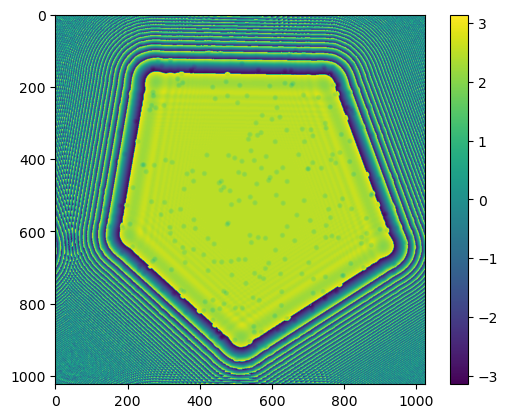

In [23]:
for i in range(par.Nframe):
    plt.imshow(np.angle(AuNPimg[:, :, i]*inwave))
    plt.colorbar()
    plt.show()

# Combined 11 Frames

In [33]:
frame_sum = np.sum(AuNPimg,-1,keepdims=True)

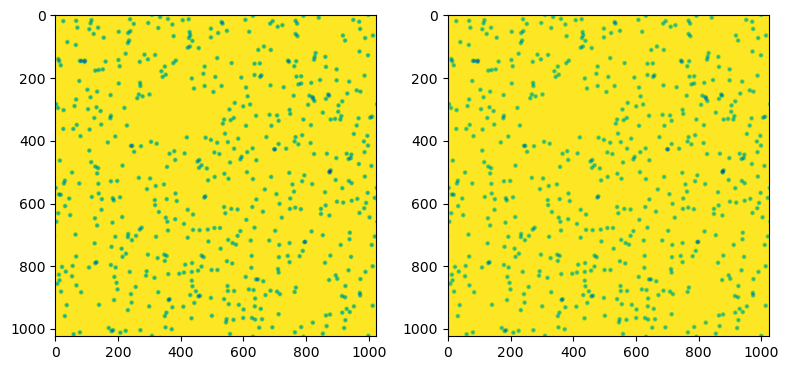

In [34]:
fig = plt.figure(figsize = [8, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.abs(frame_sum))

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.angle(frame_sum))

plt.tight_layout()
plt.show()

## Combined Diffraction Image

In [24]:
wavesample_sum = np.sum(difImg,-1,keepdims=True)

### Absolute

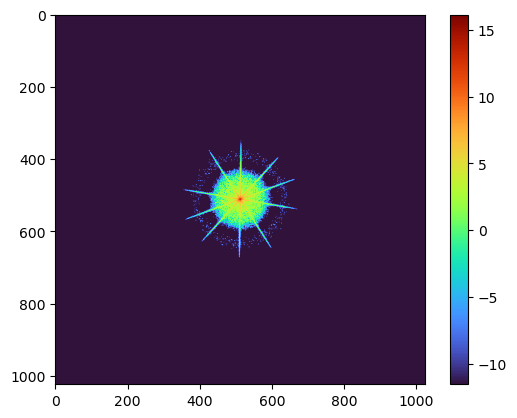

In [25]:
plt.imshow(np.log(np.abs(wavesample_sum+1e-5)), cmap="turbo")
plt.colorbar()
plt.show()

# Generate the Data (One Run)

1. abs(frame0)
2. abs(frame5)
3. angle(sumof11frames)
4. angle(frame0)
5. abs(frame5)
6. angle(sumof11frames)
7. abs(wavesample_sum)


In [31]:
arr_stack = np.stack((np.array(np.abs(AuNPimg[:,:,0])),
                      np.array(np.abs(AuNPimg[:,:,5])),
                      np.abs(frame_sum).reshape((1024,1024)),
                      np.array(np.angle(AuNPimg[:,:,0])),
                      np.array(np.angle(AuNPimg[:,:,5])),
                      np.angle(frame_sum).reshape((1024,1024)),
                      np.abs(wavesample_sum).reshape((1024,1024))
                    ))

arr_stack.shape

(9, 1024, 1024)

**Note:**

Alternatively, ``np.squeeze()`` can be used to remove dimension with 1 value

In [32]:
arr_stack = np.stack((np.array(np.abs(AuNPimg[:,:,0])),
                      np.array(np.abs(AuNPimg[:,:,5])),
                      np.abs(frame_sum).squeeze(),
                      np.array(np.angle(AuNPimg[:,:,0])),
                      np.array(np.angle(AuNPimg[:,:,5])),
                      np.angle(frame_sum).squeeze(),
                      np.abs(wavesample_sum).squeeze()
                    ))

arr_stack.shape

(9, 1024, 1024)

# Save the Array into Numpy File

## Using npy

In [33]:
np.save('data/test1', arr_stack)

## Using npz

In [66]:
np.savez('data/test1',arr_stack)

## Using npz Compressed

(9, 1024, 1024)


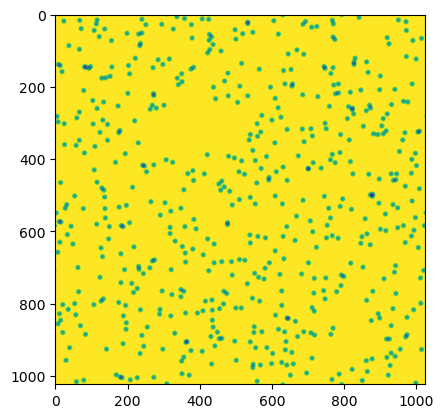

In [72]:
np.savez_compressed('data/test1compressed', arr_stack = arr_stack)
file_content = np.load('data/test1compressed.npz', allow_pickle=True)
print(file_content['arr_stack'].shape)

# Generator using Looping

In [5]:
def generate_ptycho_array(num_loop):
    # set different seed per n frame
    np.random.seed(num_loop)

    aperture = lib.calcAperture(opt, aper)
    smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
    if aper.needPropagation == 1:
        inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
    else:
        inwave = aperture

    AuNPimg = lib.calcAuNP(opt, par)

    wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
    wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

    difImg       = np.abs(wavedetector)**2

    # diffraction patterns are normalized so that its dynamic range become "opt.DR"
    maxCount     = difImg.max()
    difImg       = difImg / maxCount * 10**(opt.DR)
    isCounted    = np.where(difImg >= 1, 1, 0)
    difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

    # 2-4-3, apply photon shot noise if "opt.Wnoise" is True
    if opt.Wnoise == 1:
        difImgWnoise = np.random.poisson(difImg)

    frame_sum = np.sum(AuNPimg,-1,keepdims=True)
    wavesample_sum = np.sum(difImg,-1,keepdims=True)
    
    arr_stack = np.stack((np.array(np.abs(AuNPimg[:,:,0])),
                      np.array(np.abs(AuNPimg[:,:,5])),
                      np.abs(frame_sum).squeeze(),
                      np.array(np.angle(AuNPimg[:,:,0])),
                      np.array(np.angle(AuNPimg[:,:,5])),
                      np.angle(frame_sum).squeeze(),
                      np.abs(wavesample_sum).squeeze()
                    ))

    filename = 'data/ptychoAUNP_'+str(num_loop)
    np.savez_compressed(filename,arr_stack)
    
    return True

In [ ]:
with ProcessPoolExecutor(8) as executor:
    future = []
    for i in range(1000):
        np.random.seed(i)
        future.append(executor.submit(generate_ptycho_array, i))

    for i, f in enumerate(as_completed(future)):
        _ = f.result()
        if i % 8 == 0:
            print('Finish data for seed ', i)
            
    future.clear()

In [9]:
def generate_ptycho_array(num_loop):
    # set different seed per n frame
    np.random.seed(num_loop)

    aperture = lib.calcAperture(opt, aper)
    smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
    if aper.needPropagation == 1:
        inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
    else:
        inwave = aperture

    AuNPimg = lib.calcAuNP(opt, par)

    wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
    wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

    difImg       = np.abs(wavedetector)**2

    # diffraction patterns are normalized so that its dynamic range become "opt.DR"
    maxCount     = difImg.max()
    difImg       = difImg / maxCount * 10**(opt.DR)
    isCounted    = np.where(difImg >= 1, 1, 0)
    difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

    # 2-4-3, apply photon shot noise if "opt.Wnoise" is True
    if opt.Wnoise == 1:
        difImgWnoise = np.random.poisson(difImg)

    frame_sum = np.sum(AuNPimg,-1,keepdims=True)
    wavesample_sum = np.sum(difImg,-1,keepdims=True)
    
    arr_stack = np.stack((np.array(np.abs(AuNPimg[:,:,0])),
                      np.array(np.abs(AuNPimg[:,:,5])),
                      np.abs(frame_sum).squeeze(),
                      np.array(np.angle(AuNPimg[:,:,0])),
                      np.array(np.angle(AuNPimg[:,:,5])),
                      np.angle(frame_sum).squeeze(),
                      np.abs(wavesample_sum).squeeze()
                    ))
    
    return arr_stack

In [11]:
with ProcessPoolExecutor(8) as executor:
    future = []
    for i in range(10):
        np.random.seed(i)
        future.append(executor.submit(generate_ptycho_array, i))

    for i, f in enumerate(as_completed(future)):
        _ = f.result()
        filename = 'data1/ptychoAUNP_'+str(i)
        np.savez_compressed(filename,i)
        if i % 8 == 0:
            print('Finish data for seed ', i)
            
    future.clear()

0
0
0
00

0
0
0
1
1
1
2
2
2
3
1
3
3
1
4
1
4
4
5
1
5
5
6
1
6
2
7
6
2
7
8
7
8
9
2
8
9
10
9
3
2
10
10
3
Finish data for seed  0
0
2
0
1
1
3
2
4
3
2
4
4
3
3
3
5
4
5
4
6
4
5
5
5
7
6
8
6
6
4
7
9
7
8
10
6
5
8
9
7
9
10
10
6
5
7
7
8
8
9
9
8
10
10
6
9
7
10
8
Finish data for seed  8
9
10


In [ ]:
for i in range(1000):
    filename = 'data/ptychoAUNP_'+str(i)
    np.savez_compressed(filename,arr_stack=generate_ptycho_array(i))

In [14]:
file_content = np.load('data/ptychoAUNP_1.npz', allow_pickle=True)
file_content.files

['arr_0']

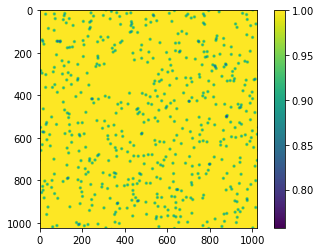

In [38]:
plt.imshow(file_content['arr_0'][0])
plt.colorbar()

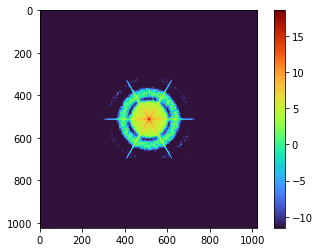

In [36]:
plt.imshow(np.log(file_content['arr_0'][6]+1e-5), cmap="turbo")
plt.colorbar()